In [1]:
import numpy as np
import pandas as pd
import loadData
import monteCarloClass
import time

# Single Particiapnt Example:

1. Select a single participant's data from the dataset.
2. Select the model parameters to analyze.
3. Load the existing model fit of specific data for that specific model of that specific participant.
4. Load the raw data psychometric data for that specific participant.
5. Load the model simulated data for that specific participant.
6. Do model simulated psychometric fits and plot them against the raw binned data.
7. Do bootstrap for data save parameters
8. Compare bootstrapped data parameters with model simulated parameter estimates.

### 1. Select a single participant's data from the dataset.


In [2]:
data, dataName = loadData.loadData("mt_all.csv")



 Total trials before cleaning
: 2156
uniqueSensory: [1.2 0.1] 
 uniqueStandard: [0.5] 
 uniqueConflict: [np.float64(-0.25), np.float64(-0.17), np.float64(-0.08), np.float64(0.0), np.float64(0.08), np.float64(0.17), np.float64(0.25)]
total trials after cleaning: 2156


### 2. Select the model parameters to analyze.


In [3]:

intensityVariable = "deltaDurS"
sensoryVar = "audNoise"
standardVar = "standardDur"
conflictVar = "conflictDur"
#s
visualStandardVar = "unbiasedVisualStandardDur"
visualTestVar = "unbiasedVisualTestDur"
audioStandardVar = "standardDur"
audioTestVar = "testDurS"
# Instantiate the Monte Carlo class
mc_fitter = monteCarloClass.OmerMonteCarlo(data)
print("Visual test duration range:", data["recordedDurVisualTest"].min(), "to", data["recordedDurVisualTest"].max())
# fit parameters
mc_fitter.nStart = 1 # Number of random starts for optimization
mc_fitter.nSimul = 500
mc_fitter.optimizationMethod= "bads"  # Use BADS for optimization
mc_fitter.modelName = "lognorm"  # Set measurement distribution to Gaussian
mc_fitter.integrationMethod = "analytical"  # Use numerical integration instead of analytical
mc_fitter.freeP_c = False  # Allow different prior widths for conflict conditions
mc_fitter.sharedLambda = False  # Use separate lapse rates for each condition
mc_fitter.dataName = dataName


Created logDurRatio variable: range [-3.000, 0.646]
  → This represents log(test/standard) for Weber's law compliance
Visual test duration range: 0.1072 to 1.0763


### 3. Load the existing model fit of specific data for that specific model of that specific participant.


In [4]:
# read back the saved file to verify
import os
import json
import loadResults
try:
    res=loadResults.loadFitResults(mc_fitter,dataName, modelName=mc_fitter.modelName)
    res_with_new_lines = json.dumps(res, indent=4)
    print("Loaded saved fit results:\n")
    print(res_with_new_lines)
    #print(f"Loaded saved fit results: {res}")
    mc_fitter.modelFit= res['fittedParams']
    mc_fitter.logLikelihood= res['logLikelihood']
    mc_fitter.aic= res['AIC']
    mc_fitter.bic= res['BIC']
    mc_fitter.nDataPoints= res['n_conditions']
except:
    print("No saved fit results found, proceeding to fit the model.")
    user_input = input("Do you want to proceed with model fitting? (yes/no): ").strip().lower()
    if user_input != 'yes':
        print("Model fitting skipped.")
        
    timeStart = time.time()
    print(f"\nFitting Causal Inference Model for {dataName} with {len(mc_fitter.groupedData)} unique conditions")
    fittedParams = mc_fitter.fitCausalInferenceMonteCarlo(mc_fitter.groupedData)
    print(f"\nFitted parameters for {dataName}: {fittedParams}")
    print(f"Time taken to fit: {time.time() - timeStart:.2f} seconds")
    mc_fitter.modelFit= fittedParams
    mc_fitter.logLikelihood= -mc_fitter.nLLMonteCarloCausal(fittedParams, mc_fitter.groupedData)    
    
    #save the fit results
    import fitSaver
    fitSaver.saveFitResultsSingle(mc_fitter, mc_fitter.modelFit, dataName)

Looking for saved fit: mt_all with model lognorm_LapseFree_sharedPrior
Loaded saved fit results:

{
    "participantID": "mt",
    "modelType": "lognorm_LapseFree_sharedPrior",
    "fittedParams": [
        0.032721803495229546,
        0.15576154849977908,
        0.3718890945007365,
        0.7982787610074273,
        0.46007481075666873,
        0.14598556138063035,
        0.21001085452070584,
        0.5957054038783781,
        2.1428683373655852
    ],
    "AIC": 2209.9903735016615,
    "BIC": 2244.9151703792677,
    "logLikelihood": -1095.9951867508307,
    "n_conditions": 358
}


## Simulate data using fitted parameters

### 4. Load the raw data psychometric data for that specific participant.


In [5]:
#proceed to simulate and save to {filename}
from loadSimData import loadSimulatedData
mc_fitter.simulatedData=loadSimulatedData(fitter=mc_fitter, dataName=mc_fitter.dataName, participantID=dataName.split(".csv")[0], modelType=mc_fitter.modelName)


Loaded saved simulated data from simulated_data/mt/mt_lognorm_LapseFree_sharedPrior_simulated.csv


In [22]:
# Load psychometric fits for both data and simulated data
import importlib
import psychometricFitLoader as pfl_data
import psychometricFitLoader_simulated as pfl_sim

# Get participant ID
dataID = dataName.split("_")[0]

# Load real data psychometric fit
mc_fitter.dataFit = pfl_data.load_psychometric_fit(dataID)
print(f"   AIC: {mc_fitter.dataFit['AIC']:.2f}, Params: {mc_fitter.dataFit['n_params']}")
a= mc_fitter.dataFit["parameters"]
def SimpleNamespace(**kwargs):
    class Namespace:
        def __init__(self, **kwargs):
            for key, value in kwargs.items():
                setattr(self, key, value)
    return Namespace(**kwargs)

mc_fitter.dataFit = SimpleNamespace(**mc_fitter.dataFit)


mc_fitter.dataFit.x = a
print(f"✅ Loaded real data psychometric fit for {dataID}")



   AIC: 2232.57, Params: 42
✅ Loaded real data psychometric fit for mt



### 5. Load the model simulated data for that specific participant.

6. Do model simulated psychometric fits and plot them against the raw binned data.


In [7]:

mc_fitter.simDataFit=mc_fitter.fitMultipleStartingPoints(mc_fitter.simulatedData,1)

Created logDurRatio variable: range [-3.081, 0.644]
  → This represents log(test/standard) for Weber's law compliance


# Plot the fits

Plotting psychometric curves for Monte Carlo model and data...
Noise: 0.1, Conflict: -0.25, Lambda: 0.210, Sigma_a: 0.156, Sigma_v: 0.372, p_c: 0.798
Noise: 0.1, Conflict: -0.17, Lambda: 0.033, Sigma_a: 0.156, Sigma_v: 0.372, p_c: 0.798
Noise: 0.1, Conflict: -0.08, Lambda: 0.146, Sigma_a: 0.156, Sigma_v: 0.372, p_c: 0.798
Noise: 0.1, Conflict: 0.0, Lambda: 0.033, Sigma_a: 0.156, Sigma_v: 0.372, p_c: 0.798
Noise: 0.1, Conflict: 0.08, Lambda: 0.210, Sigma_a: 0.156, Sigma_v: 0.372, p_c: 0.798
Noise: 0.1, Conflict: 0.17, Lambda: 0.146, Sigma_a: 0.156, Sigma_v: 0.372, p_c: 0.798
Noise: 0.1, Conflict: 0.25, Lambda: 0.033, Sigma_a: 0.156, Sigma_v: 0.372, p_c: 0.798
Noise: 1.2, Conflict: -0.25, Lambda: 0.210, Sigma_a: 0.460, Sigma_v: 0.372, p_c: 0.798
Noise: 1.2, Conflict: -0.17, Lambda: 0.033, Sigma_a: 0.460, Sigma_v: 0.372, p_c: 0.798
Noise: 1.2, Conflict: -0.08, Lambda: 0.146, Sigma_a: 0.460, Sigma_v: 0.372, p_c: 0.798
Noise: 1.2, Conflict: 0.0, Lambda: 0.033, Sigma_a: 0.460, Sigma_v: 0.372

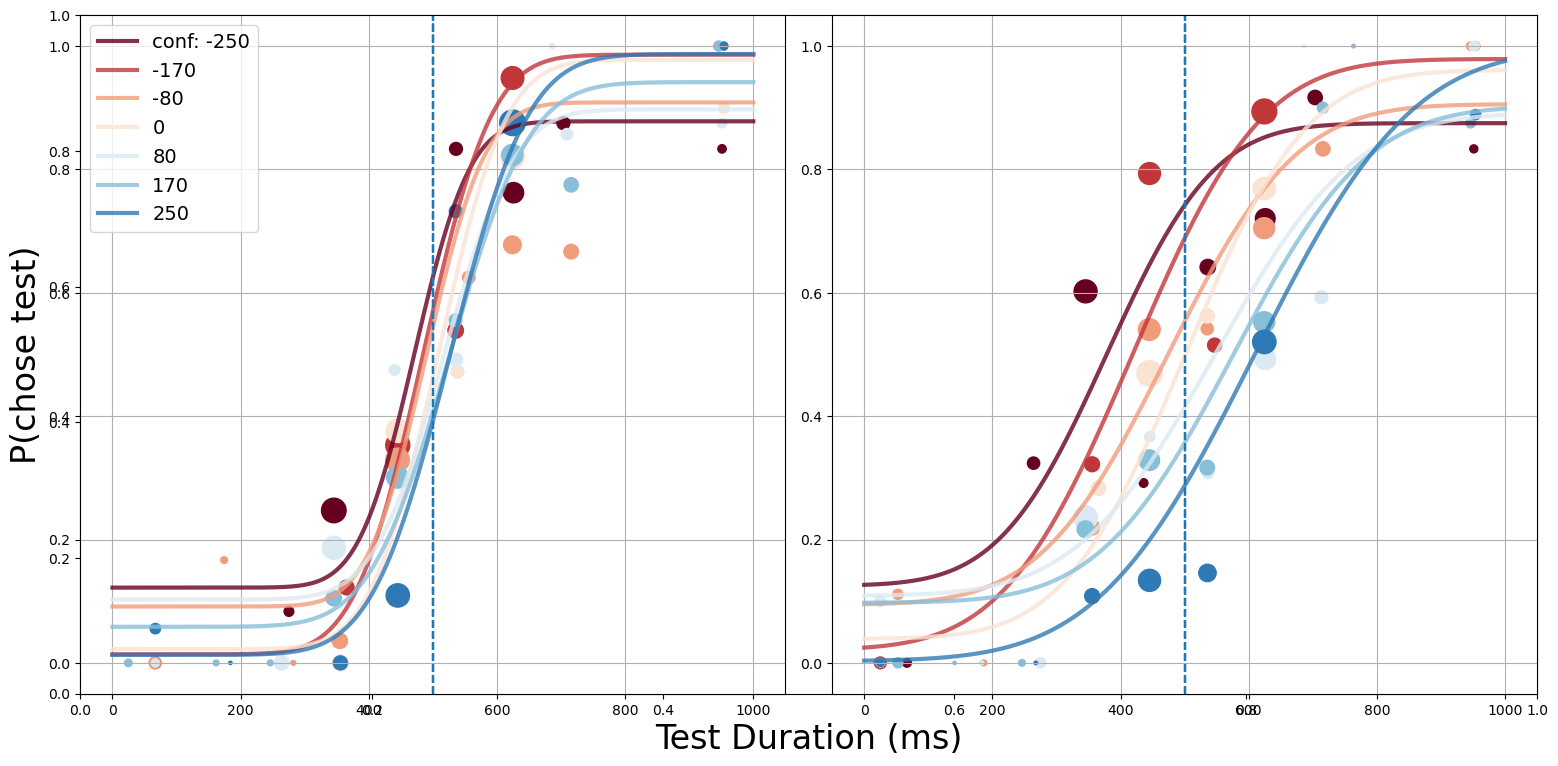

In [8]:
from matplotlib import pyplot as plt
import seaborn as sns
def bin_and_plot(data, bin_method='cut', bins=10, bin_range=None, plot=True,color="blue",binVar='delta_dur_percents'):
    if bin_method == 'cut':
        data['bin'] = pd.cut(data[binVar], bins=bins, labels=False, include_lowest=True, retbins=False)
    elif bin_method == 'manual':
        data['bin'] = np.digitize(data[binVar], bins=bin_range) - 1
    
    grouped = data.groupby('bin').agg(
        x_mean=(binVar, 'mean'),
        y_mean=('p_choose_test', 'mean'),
        total_resp=('total_responses', 'sum')
    )

    if plot:
        plt.scatter(grouped['x_mean'], grouped['y_mean'], s=grouped['total_resp']/data['total_responses'].sum()*900, color=color)

def plotPsychometrics_MC_Data(self):
    "use self to get the  required stuff"
    print("Plotting psychometric curves for Monte Carlo model and data...")
    pltTitle = self.dataName + " "+ self.modelName+" Model Fit"
    plt.figure(figsize=(16, 8))
    #plt.title(f"{pltTitle} AV,A duration comparison", fontsize=26)
    plt.xlabel("Test Duration (ms)", fontsize=24)
    plt.ylabel("P(chose test)",fontsize=24)

    for i, standardLevel in enumerate(self.uniqueStandard):
        for j, audioNoiseLevel in enumerate(sorted(self.uniqueSensory)):
            for k, conflictLevel in enumerate(self.uniqueConflict):
                plt.subplot(1, 2, j + 1)
                x = np.linspace(-0.6, 0.6, 1000)
                color = sns.color_palette("RdBu", as_cmap=True)(k / len(self.uniqueConflict))
                

                paramsSimFit=self.getParams(self.simDataFit.x, conflictLevel,audioNoiseLevel)
                # Plot data fit: plot psychometric curve from fitted data
                ySimSigmoid=self.psychometric_function(x, paramsSimFit[0],paramsSimFit[1],paramsSimFit[2])

                
                xPlot=np.linspace(0,1000,1000)
                if k==0:
                    plt.plot(xPlot, ySimSigmoid, color=color, linestyle='-', label=f"conf: {int(conflictLevel*1000)}", linewidth=3, alpha=0.8)
                else:
                    plt.plot(xPlot, ySimSigmoid, color=color, linestyle='-', linewidth=3, alpha=0.8,label=f"{int(conflictLevel*1000)}")
                plt.axvline(500, linestyle='--')


                "plot the monte carlo"
                lambda_, sigma_av_a, sigma_av_v, p_c ,tmin,tmax= self.getParamsCausal(self.modelFit, audioNoiseLevel, conflictLevel)

        
                #plt.axvline(x=0, color='gray', linestyle='--')
                #plt.axhline(y=0.5, color='gray', linestyle='--')
                #plt.xlabel(f"({self.intensityVar}) Test(stair-a)-Standard(a) Duration Difference Ratio(%)")
                #plt.xlabel("Test Duration (ms)", fontsize=24)
                #plt.title(f"{pltTitle} AV,A Duration Comp. Noise: {audioNoiseLevel}", fontsize=26)
                if j==0:
                    plt.legend(fontsize=14, title_fontsize=20)
                plt.grid()


                groupedDataSub = self.groupByChooseTest(
                    self.data[(self.data[self.standardVar] == standardLevel) & (self.data[self.sensoryVar] == audioNoiseLevel) & (self.data[self.conflictVar] == conflictLevel)],
                    [self.intensityVar, self.sensoryVar, self.standardVar, self.conflictVar, self.visualStandardVar, self.visualTestVar, self.audioTestVar, "testDurMs"]
                )
                bin_and_plot(groupedDataSub, bin_method='cut', bins=10, plot=True, color=color,binVar='testDurMs')
                #plt.text(0.05, 0.8, fr"$\sigma_a$: {sigma_av_a:.2f}, $\sigma_v$: {sigma_av_v:.2f},", fontsize=12, ha='left', va='top', transform=plt.gca().transAxes)
                plt.tight_layout()
                #plt.grid(True)
                print(f"Noise: {audioNoiseLevel}, Conflict: {conflictLevel}, Lambda: {lambda_:.3f}, Sigma_a: {sigma_av_a:.3f}, Sigma_v: {sigma_av_v:.3f}, p_c: {p_c:.3f}")
                #plt.text(0.15, 0.9, f"P(C=1): {p_c:.2f}", fontsize=12, ha='center', va='bottom', transform=plt.gca().transAxes)
                
    plt.show()

plotPsychometrics_MC_Data(mc_fitter)

# Bootstrapped parameters

In [9]:
nBoots=1
## data bootstrap for mu vs conflict
dataBoots=mc_fitter.paramBootstrap( mc_fitter.dataFit.x, nBoots=nBoots)


Bootstrapping: 100%|██████████| 1/1 [00:11<00:00, 11.15s/iteration]


In [10]:
from bootstrapperSaveLoad import saveBootstrappedParams, loadBootstrappedParams
saveBootstrappedParams(mc_fitter, dataBoots, mc_fitter.dataName)
loadBootstrappedParams(mc_fitter, mc_fitter.dataName)

Bootstrapped parameters saved to bootstrapped_params/mt/mt_lognorm_LapseFree_sharedPrior_bootstrapped_params.json
Saved array shape: (1, 42)
Bootstrapped parameters file not found: bootstrapped_params/mt/mt_gaussian_LapseFree_sharedPrior_bootstrapped_params.json


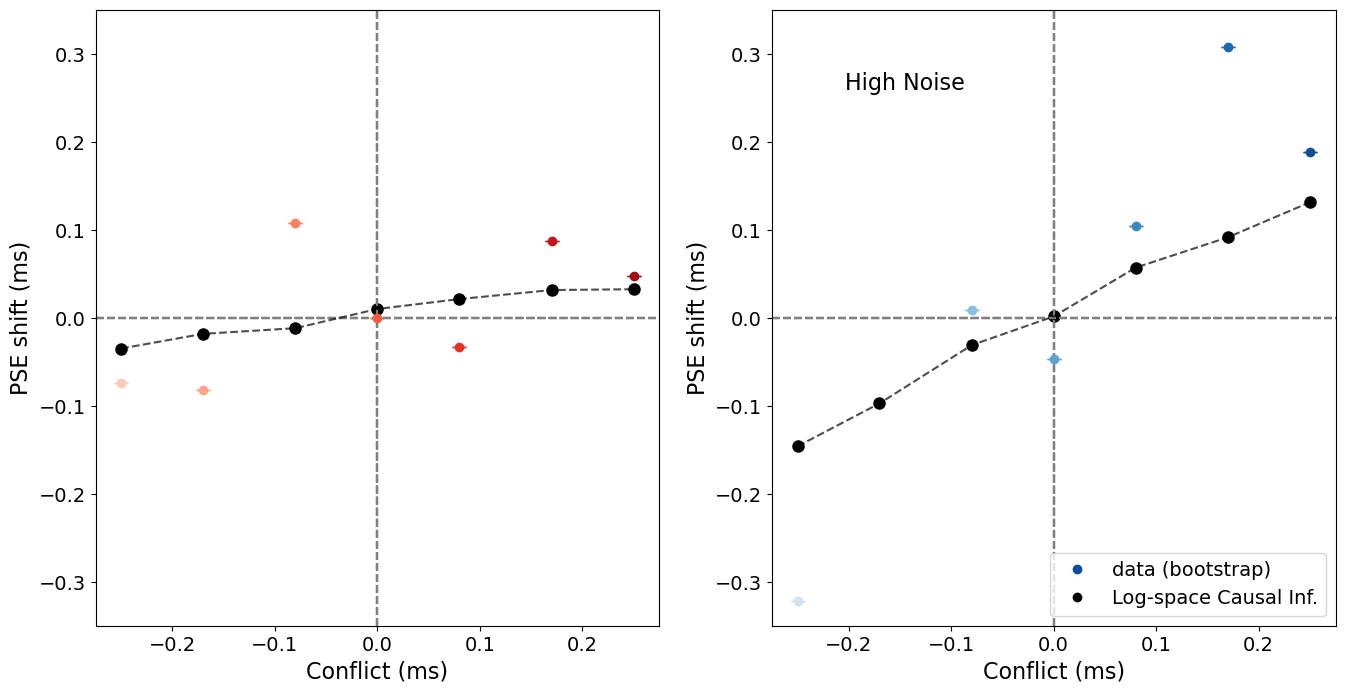

In [11]:

import matplotlib.pyplot as plt
import seaborn as sns  
def plot_mu_vs_conflict_MC_vs_Data(self):
    plt.figure(figsize=(16, 8))
    #plt.title(f"Mean Shift in PSE vs Conflict Level", fontsize=16)
    for i, standardLevel in enumerate(self.uniqueStandard):
        for j, audioNoiseLevel in enumerate(sorted(self.uniqueSensory)):
            conflict_levels = []
            mu_models = []  
            for k, conflictLevel in enumerate(self.uniqueConflict):
                conflict_levels.append(conflictLevel)


                plt.subplot(1, 2, j + 1)
                color = sns.color_palette("viridis", as_cmap=True)(k / len(self.uniqueConflict))
                
                # Plot bootstrap data fits
                for boot in dataBoots:
                    paramsBootDf = self.getParams(boot, conflictLevel, audioNoiseLevel)  # lambda mu sigma
                    muBoot = paramsBootDf[1]
                    #plt.scatter(conflictLevel, muBoot, color=color, s=10, alpha=0.1)
                # plot bootstrap mean
                bootMus = [self.getParams(boot, conflictLevel, audioNoiseLevel)[1] for boot in dataBoots]
                #plt.scatter(conflictLevel, np.mean(bootMus), color=color, s=20, alpha=0.7, label=f"Data Noise: {audioNoiseLevel}ms, Conflict: {conflictLevel}ms")
                #plot error bars

                if audioNoiseLevel == 0.1:
                    color = sns.color_palette("Reds", as_cmap=True)(0.2 + 0.8 * (k / len(self.uniqueConflict)))
                elif audioNoiseLevel == 1.2:
                    color = sns.color_palette("Blues", as_cmap=True)(0.2+ 0.8 * (k / len(self.uniqueConflict)))

                plt.errorbar(conflictLevel, np.mean(bootMus), yerr=np.std(bootMus), color=color, fmt='o', capsize=5, alpha=1)

                paramsSimDf = self.getParams(self.simDataFit.x, conflictLevel, audioNoiseLevel)  # lambda mu sigma
                muModel = paramsSimDf[1]
                #muData = self.getParams(self.dataFit.x, conflictLevel, audioNoiseLevel)[1]
                mu_models.append(muModel)

                #plt.scatter(conflictLevel, muData, color="red", s=40, alpha=0.7)
                #plt.scatter(conflictLevel, muModel, color="blue", s=40,  alpha=0.7)
                # or instead plot it as line plot
                #plt.plot(conflictLevel_sorted, muModel_sorted, color="blue", alpha=0.7, linestyle='--', marker='o', markersize=8)

                plt.plot(conflictLevel, muModel, color="black",  alpha=1,linestyle='--',marker='o',markersize=8)
                plt.xlabel(f"Conflict (ms)", fontsize=16)
                plt.ylabel("PSE shift (ms)", fontsize=16)
                plt.axhline(y=0, color='gray', linestyle='--')
                plt.axvline(x=0, color='gray', linestyle='--')
                plt.ylim(-0.35, 0.35)
                #plt.title(f"{self.dataName} AV,A Duration Comp. Noise: {audioNoiseLevel}", fontsize=16)

                plt.xticks(fontsize=14)
                plt.yticks(fontsize=14)

    
            # Convert lists to arrays and sort them for a proper line plot
            conflict_levels = np.array(conflict_levels)
            mu_models = np.array(mu_models)

            sorted_indices = np.argsort(conflict_levels)
            conflict_levels_sorted = conflict_levels[sorted_indices]
            mu_models_sorted = mu_models[sorted_indices]
            plt.plot(conflict_levels_sorted, mu_models_sorted, color="black", alpha=0.7, linestyle='--')


    plt.plot([], [], 'o', color=color, label='data (bootstrap)')
    plt.plot([], [], 'o', color='black', label='Log-space Causal Inf.')
    dictNoise = {0.1: 'Low Noise', 1.2: 'High Noise'}
    plt.text(0.13, 0.9, f"{dictNoise[audioNoiseLevel]}", fontsize=16, ha='left', va='top', transform=plt.gca().transAxes)
    plt.legend(fontsize=14, title_fontsize=14)
                                
    plt.show()


plot_mu_vs_conflict_MC_vs_Data(mc_fitter)
#mc_fitter.plot_mu_vs_conflict_MC_vs_Data()


# Forced Fusion Model: Reliability-Based Weighted Averaging

Now we'll:
1. Load unimodal auditory and visual data for this participant
2. Fit psychometric functions with `fixedMu=True` (no bias expected for unimodal)
3. Extract unimodal sigma estimates (reliability measures)
4. Generate forced fusion predictions using reliability-weighted averaging

## Step 1: Load Unimodal Data

In [12]:
# Get participant ID from current data
participant_id = dataName.split("_")[0]
print(f"Participant: {participant_id}")

# Construct unimodal data filenames
auditory_filename = f"{participant_id}_auditoryDurEst_2025-06-16_12h17.46.950.csv"
visual_filename = f"{participant_id}_visualDurEst_2025-06-16_12h38.51.056.csv"

from psychometric_fitter import PsychometricFitter

# Initialize with fix_mu=True for unimodal data (no bias expected)
audFitter = PsychometricFitter(data_path=auditory_filename, fix_mu=True)
visualFitter = PsychometricFitter(data_path=visual_filename, fix_mu=True)

print(f"Loading unimodal data:")
print(f"  Auditory: {auditory_filename} (fix_mu=True)")
print(f"  Visual: {visual_filename} (fix_mu=True)")


Participant: mt
Unique sensory levels: [1.2 0.1]
Unique standard levels: [0.5]
Unique conflict levels: [np.float64(0.0)]
Unique sensory levels: [0.1]
Unique standard levels: [0.5]
Unique conflict levels: [np.int64(0)]
Loading unimodal data:
  Auditory: mt_auditoryDurEst_2025-06-16_12h17.46.950.csv (fix_mu=True)
  Visual: mt_visualDurEst_2025-06-16_12h38.51.056.csv (fix_mu=True)


In [13]:
# Check what's in the data first
print("Auditory data info:")
print(f"  Unique sensory levels: {audFitter.unique_sensory}")
print(f"  Unique conflicts: {audFitter.unique_conflict}")
print(f"  Unique standards: {audFitter.unique_standard}")

print("\nVisual data info:")
print(f"  Unique sensory levels: {visualFitter.unique_sensory}")
print(f"  Unique conflicts: {visualFitter.unique_conflict}")
print(f"  Unique standards: {visualFitter.unique_standard}")

# Fit the models
print("\nFitting auditory psychometric function...")
audFitter.fit(n_start=1)

print("\nFitting visual psychometric function...")
visualFitter.fit(n_start=1)


Auditory data info:
  Unique sensory levels: [1.2 0.1]
  Unique conflicts: [np.float64(0.0)]
  Unique standards: [0.5]

Visual data info:
  Unique sensory levels: [0.1]
  Unique conflicts: [np.int64(0)]
  Unique standards: [0.5]

Fitting auditory psychometric function...

Best fit NLL: 167.79
Fitted parameters: [0.14443439 2.         0.22536305 0.10950283 0.10950283]

Fitting visual psychometric function...

Best fit NLL: 60.79
Fitted parameters: [0.04715672 0.5065616  0.08206492]


  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 60.793294780057565
        x: [ 4.716e-02  5.066e-01  8.206e-02]
      nit: 10
      jac: [-2.700e-05 -2.842e-05  0.000e+00]
     nfev: 52
     njev: 13
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>

In [14]:
# Extract parameters for different conditions
# Use the actual conflict values from the data (usually 0.0 for unimodal)
aud_conflict = audFitter.unique_conflict[0]  # Get first conflict value
vis_conflict = visualFitter.unique_conflict[0]

# For auditory: get parameters for each noise level
print("Extracting auditory parameters:")
aud_params_by_noise = {}
for noise_level in sorted(audFitter.unique_sensory):
    params = audFitter.get_condition_params(audio_noise=noise_level, conflict=aud_conflict)
    aud_params_by_noise[noise_level] = params
    print(f"\n  Noise level {noise_level}:")
    print(f"    λ = {params['lambda']:.3f}")
    print(f"    μ = {params['mu']:.3f}")
    print(f"    σ = {params['sigma']:.3f}")

# For visual: typically only one condition
print("\n\nExtracting visual parameters:")
vis_params = visualFitter.get_condition_params(conflict=vis_conflict)
print(f"  λ = {vis_params['lambda']:.3f}")
print(f"  μ = {vis_params['mu']:.3f}")
print(f"  σ = {vis_params['sigma']:.3f}")

# Store for later use - map noise levels to condition names
noise_to_name = {}
noise_levels_sorted = sorted(audFitter.unique_sensory)
if len(noise_levels_sorted) >= 2:
    noise_to_name[noise_levels_sorted[0]] = 'low_noise'
    noise_to_name[noise_levels_sorted[1]] = 'high_noise'
    aud_low_noise_params = aud_params_by_noise[noise_levels_sorted[0]]
    aud_high_noise_params = aud_params_by_noise[noise_levels_sorted[1]]
else:
    # Only one noise level
    noise_to_name[noise_levels_sorted[0]] = 'single_noise'
    aud_low_noise_params = aud_params_by_noise[noise_levels_sorted[0]]
    aud_high_noise_params = None

print(f"\n✅ Parameters extracted successfully")


Extracting auditory parameters:

  Noise level 0.1:
    λ = 0.144
    μ = 0.000
    σ = 0.225

  Noise level 1.2:
    λ = 0.144
    μ = 0.000
    σ = 2.000


Extracting visual parameters:
  λ = 0.047
  μ = 0.000
  σ = 0.507

✅ Parameters extracted successfully


## Step 3: Extract Unimodal Sigmas (Reliability Measures)

Sigma represents discrimination threshold - lower sigma = higher reliability

In [15]:
# Extract unimodal sigmas for each noise condition
# Get sensory sigma (divide by sqrt(2) to get single-sample noise)

sigma_vis = vis_params['sigma'] / np.sqrt(2)
print("Unimodal Sensory Sigma Estimates (σ/√2):")
print(f"  σ_visual = {sigma_vis:.4f}")

forced_fusion_params = {}

# Process each auditory noise condition
for noise_level, condition_name in noise_to_name.items():
    aud_params = aud_params_by_noise[noise_level]
    sigma_aud = aud_params['sigma'] / np.sqrt(2)
    
    print(f"  σ_auditory ({condition_name}, noise={noise_level}) = {sigma_aud:.4f}")
    
    # Calculate reliability weights
    w_aud = 1 / (sigma_aud**2)
    w_vis = 1 / (sigma_vis**2)
    w_aud_norm = w_aud / (w_aud + w_vis)
    w_vis_norm = w_vis / (w_aud + w_vis)
    
    # Predicted bimodal sigma (optimal integration)
    sigma_bimodal = 1 / np.sqrt(w_aud + w_vis)
    
    print(f"\n  Reliability Weights ({condition_name}):")
    print(f"    w_auditory = {w_aud_norm:.3f} ({w_aud_norm*100:.1f}%)")
    print(f"    w_visual   = {w_vis_norm:.3f} ({w_vis_norm*100:.1f}%)")
    print(f"  Predicted σ_bimodal = {sigma_bimodal:.4f}\n")
    
    # Store in dictionary
    forced_fusion_params[condition_name] = {
        'noise_level': noise_level,
        'w_auditory': w_aud_norm,
        'w_visual': w_vis_norm,
        'sigma_predicted': sigma_bimodal,
        'sigma_aud': sigma_aud,
        'sigma_vis': sigma_vis
    }

print(f"✅ Calculated forced fusion parameters for {len(forced_fusion_params)} condition(s)")


Unimodal Sensory Sigma Estimates (σ/√2):
  σ_visual = 0.3582
  σ_auditory (low_noise, noise=0.1) = 0.1594

  Reliability Weights (low_noise):
    w_auditory = 0.835 (83.5%)
    w_visual   = 0.165 (16.5%)
  Predicted σ_bimodal = 0.1456

  σ_auditory (high_noise, noise=1.2) = 1.4142

  Reliability Weights (high_noise):
    w_auditory = 0.060 (6.0%)
    w_visual   = 0.940 (94.0%)
  Predicted σ_bimodal = 0.3472

✅ Calculated forced fusion parameters for 2 condition(s)


## Step 4: Generate Forced Fusion Predictions

Forced fusion assumes:
- Always integrate (no causal inference)
- Weighted average based on reliability: $\hat{s} = w_a \cdot s_a + w_v \cdot s_v$
- Optimal integration: $\sigma_{av}^2 = (\frac{1}{\sigma_a^2} + \frac{1}{\sigma_v^2})^{-1}$

In [16]:
# Generate forced fusion predictions for bimodal data
def predict_forced_fusion_mu(conflict_dur_s, standard_dur_s, w_visual):
    """
    Predict PSE shift under forced fusion model in log space.
    
    For bimodal AV task with conflict:
    - Auditory percept: log(standard)
    - Visual percept: log(standard + conflict) 
    - Fused percept (log space): w_a * log(standard) + w_v * log(standard + conflict)
    - PSE shift in log space: mu = log(fused_percept / standard)
    """
    w_auditory = 1 - w_visual
    
    log_standard = np.log(standard_dur_s)
    log_visual = np.log(standard_dur_s + conflict_dur_s)
    
    # Fused estimate in log space
    log_fused = w_auditory * log_standard + w_visual * log_visual
    
    # PSE shift: difference from standard in log space
    mu_predicted = log_fused - log_standard
    
    return mu_predicted


print("="*60)
print("Forced Fusion Model Predictions")
print("="*60)

# Get standard duration from bimodal data
standard_dur = mc_fitter.uniqueStandard[0]

# Map bimodal noise levels to unimodal condition names
# Need to match mc_fitter noise levels with auditory noise levels
bimodal_noise_levels = sorted(mc_fitter.uniqueSensory)

# Generate predictions for each noise condition
for condition_name, params in forced_fusion_params.items():
    noise_level = params['noise_level']
    
    print(f"\n{condition_name.upper().replace('_', ' ')} (noise={noise_level}):")
    print(f"  Weights: w_a={params['w_auditory']:.3f}, w_v={params['w_visual']:.3f}")
    print(f"  Predicted σ_bimodal = {params['sigma_predicted']:.4f}")
    print(f"\n  Conflict Level → Predicted μ (log space) → PSE shift (ms):")
    
    params['predictions'] = {}
    
    for conflict in sorted(mc_fitter.uniqueConflict):
        mu_pred = predict_forced_fusion_mu(conflict, standard_dur, params['w_visual'])
        pse_shift_ms = PsychometricFitter.mu_to_pse_shift(mu_pred, standard_dur) * 1000
        
        params['predictions'][conflict] = {
            'mu': mu_pred,
            'pse_shift_ms': pse_shift_ms
        }
        
        print(f"    {conflict*1000:>6.0f} ms → μ={mu_pred:>7.4f} → {pse_shift_ms:>+7.1f} ms")

print("\n" + "="*60)
print(f"✅ Forced fusion predictions generated for {len(forced_fusion_params)} condition(s)")
print("="*60)

# Store predictions in mc_fitter for later plotting
mc_fitter.forced_fusion_params = forced_fusion_params

# Also create a mapping from bimodal noise levels to condition names
mc_fitter.noise_to_condition = {}
for i, bimodal_noise in enumerate(bimodal_noise_levels):
    if i < len(list(forced_fusion_params.keys())):
        mc_fitter.noise_to_condition[bimodal_noise] = list(forced_fusion_params.keys())[i]
        print(f"Mapped bimodal noise {bimodal_noise} → {list(forced_fusion_params.keys())[i]}")


Forced Fusion Model Predictions

LOW NOISE (noise=0.1):
  Weights: w_a=0.835, w_v=0.165
  Predicted σ_bimodal = 0.1456

  Conflict Level → Predicted μ (log space) → PSE shift (ms):
      -250 ms → μ=-0.1145 →   -54.1 ms
      -170 ms → μ=-0.0687 →   -33.2 ms
       -80 ms → μ=-0.0288 →   -14.2 ms
         0 ms → μ= 0.0000 →    +0.0 ms
        80 ms → μ= 0.0245 →   +12.4 ms
       170 ms → μ= 0.0484 →   +24.8 ms
       250 ms → μ= 0.0670 →   +34.6 ms

HIGH NOISE (noise=1.2):
  Weights: w_a=0.060, w_v=0.940
  Predicted σ_bimodal = 0.3472

  Conflict Level → Predicted μ (log space) → PSE shift (ms):
      -250 ms → μ=-0.6514 →  -239.3 ms
      -170 ms → μ=-0.3905 →  -161.6 ms
       -80 ms → μ=-0.1638 →   -75.6 ms
         0 ms → μ= 0.0000 →    +0.0 ms
        80 ms → μ= 0.1395 →   +74.8 ms
       170 ms → μ= 0.2750 →  +158.3 ms
       250 ms → μ= 0.3810 →  +231.9 ms

✅ Forced fusion predictions generated for 2 condition(s)
Mapped bimodal noise 0.1 → low_noise
Mapped bimodal noise 1.2 → h

## Step 5: Compare Forced Fusion vs Causal Inference Predictions

Plot the forced fusion predictions against the causal inference model and actual data

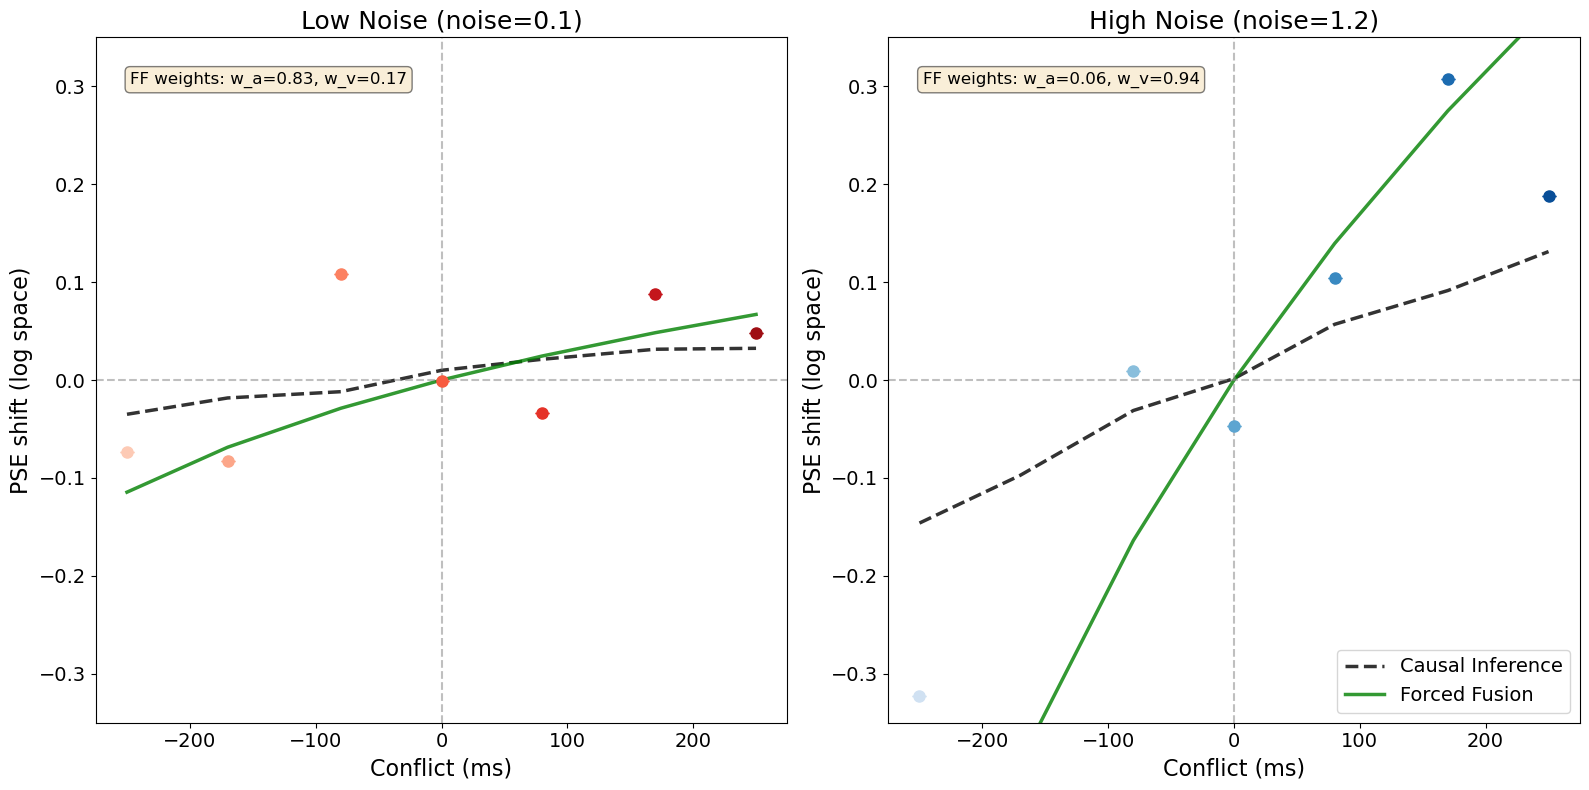

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_forced_fusion_comparison(self):
    """
    Compare forced fusion predictions with causal inference model and data
    """
    plt.figure(figsize=(16, 8))
    
    # Get noise-to-condition mapping
    if not hasattr(self, 'noise_to_condition'):
        print("⚠️ Warning: noise_to_condition mapping not found. Skipping plot.")
        return
    
    for j, audioNoiseLevel in enumerate(sorted(self.uniqueSensory)):
        plt.subplot(1, 2, j + 1)
        
        # Get forced fusion parameters for this noise condition
        if audioNoiseLevel not in self.noise_to_condition:
            print(f"⚠️ Warning: No forced fusion params for noise level {audioNoiseLevel}")
            continue
            
        condition_name = self.noise_to_condition[audioNoiseLevel]
        ff_params = self.forced_fusion_params[condition_name]
        
        conflict_levels = []
        mu_causal_inf = []
        mu_forced_fusion = []
        
        for k, conflictLevel in enumerate(self.uniqueConflict):
            conflict_levels.append(conflictLevel * 1000)  # Convert to ms
            
            # Color scheme: gradient for data points
            if j == 0:
                color = sns.color_palette("Reds", as_cmap=True)(0.2 + 0.8 * (k / len(self.uniqueConflict)))
            else:
                color = sns.color_palette("Blues", as_cmap=True)(0.2 + 0.8 * (k / len(self.uniqueConflict)))
            
            # Get data bootstrap fits (mu from psychometric fits)
            bootMus = [self.getParams(boot, conflictLevel, audioNoiseLevel)[1] for boot in dataBoots]
            mu_data_mean = np.mean(bootMus)
            mu_data_std = np.std(bootMus)
            
            # Plot data with error bars
            plt.errorbar(conflictLevel * 1000, mu_data_mean, yerr=mu_data_std, 
                        color=color, fmt='o', capsize=5, alpha=1, markersize=8)
            
            # Get causal inference model prediction
            paramsSimDf = self.getParams(self.simDataFit.x, conflictLevel, audioNoiseLevel)
            mu_ci = paramsSimDf[1]
            mu_causal_inf.append(mu_ci)
            
            # Get forced fusion prediction
            mu_ff = ff_params['predictions'][conflictLevel]['mu']
            mu_forced_fusion.append(mu_ff)
        
        # Sort for line plots
        conflict_levels = np.array(conflict_levels)
        mu_causal_inf = np.array(mu_causal_inf)
        mu_forced_fusion = np.array(mu_forced_fusion)
        
        sorted_idx = np.argsort(conflict_levels)
        conflict_sorted = conflict_levels[sorted_idx]
        mu_ci_sorted = mu_causal_inf[sorted_idx]
        mu_ff_sorted = mu_forced_fusion[sorted_idx]
        
        # Plot model predictions as lines
        plt.plot(conflict_sorted, mu_ci_sorted, 'k--', linewidth=2.5, 
                label='Causal Inference', alpha=0.8)
        plt.plot(conflict_sorted, mu_ff_sorted, 'g-', linewidth=2.5, 
                label='Forced Fusion', alpha=0.8)
        
        # Formatting
        plt.xlabel("Conflict (ms)", fontsize=16)
        plt.ylabel("PSE shift (log space)", fontsize=16)
        plt.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
        plt.axvline(x=0, color='gray', linestyle='--', alpha=0.5)
        plt.title(f"{condition_name.replace('_', ' ').title()} (noise={audioNoiseLevel})", fontsize=18)
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        plt.ylim(-0.35, 0.35)
        
        # Add reliability weight info
        plt.text(0.05, 0.95, 
                f"FF weights: w_a={ff_params['w_auditory']:.2f}, w_v={ff_params['w_visual']:.2f}",
                transform=plt.gca().transAxes, fontsize=12, 
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
        
        if j == 1:
            plt.legend(fontsize=14, loc='best')
    
    plt.tight_layout()
    plt.show()

# Plot the comparison
plot_forced_fusion_comparison(mc_fitter)


## Step 6: Quantitative Model Comparison

Calculate prediction errors and compare which model better fits the data

In [18]:
# Calculate prediction errors for each model
def calculate_model_errors(self, dataBoots):
    """
    Calculate RMSE and MAE for causal inference and forced fusion models
    """
    if not hasattr(self, 'noise_to_condition'):
        print("⚠️ Warning: noise_to_condition mapping not found. Cannot calculate errors.")
        return None
    
    results = []
    
    for audioNoiseLevel in sorted(self.uniqueSensory):
        if audioNoiseLevel not in self.noise_to_condition:
            print(f"⚠️ Skipping noise level {audioNoiseLevel} - no forced fusion params")
            continue
            
        condition_name = self.noise_to_condition[audioNoiseLevel]
        ff_params = self.forced_fusion_params[condition_name]
        
        ci_errors = []
        ff_errors = []
        
        for conflictLevel in self.uniqueConflict:
            # Get mean data mu from bootstraps
            bootMus = [self.getParams(boot, conflictLevel, audioNoiseLevel)[1] for boot in dataBoots]
            mu_data = np.mean(bootMus)
            
            # Get causal inference prediction
            paramsSimDf = self.getParams(self.simDataFit.x, conflictLevel, audioNoiseLevel)
            mu_ci = paramsSimDf[1]
            
            # Get forced fusion prediction
            mu_ff = ff_params['predictions'][conflictLevel]['mu']
            
            # Calculate errors
            ci_error = mu_ci - mu_data
            ff_error = mu_ff - mu_data
            
            ci_errors.append(ci_error)
            ff_errors.append(ff_error)
            
            results.append({
                'noise': audioNoiseLevel,
                'conflict': conflictLevel * 1000,
                'data_mu': mu_data,
                'ci_mu': mu_ci,
                'ff_mu': mu_ff,
                'ci_error': ci_error,
                'ff_error': ff_error
            })
        
        # Calculate summary statistics
        rmse_ci = np.sqrt(np.mean(np.array(ci_errors)**2))
        rmse_ff = np.sqrt(np.mean(np.array(ff_errors)**2))
        mae_ci = np.mean(np.abs(ci_errors))
        mae_ff = np.mean(np.abs(ff_errors))
        
        print(f"\nNoise Level: {audioNoiseLevel} ({condition_name})")
        print(f"  Causal Inference: RMSE={rmse_ci:.4f}, MAE={mae_ci:.4f}")
        print(f"  Forced Fusion:    RMSE={rmse_ff:.4f}, MAE={mae_ff:.4f}")
        print(f"  Better model: {'Causal Inference' if rmse_ci < rmse_ff else 'Forced Fusion'} (by RMSE)")
    
    if not results:
        return None
        
    # Create summary DataFrame
    results_df = pd.DataFrame(results)
    return results_df

# Calculate and display errors
print("="*60)
print("Model Comparison: Prediction Errors")
print("="*60)

error_df = calculate_model_errors(mc_fitter, dataBoots)

if error_df is not None:
    # Display detailed comparison table
    print("\nDetailed Predictions by Condition:")
    print(error_df.to_string(index=False, float_format=lambda x: f'{x:.4f}'))
    
    # Overall comparison
    print("\n" + "="*60)
    ci_rmse_overall = np.sqrt(np.mean(error_df['ci_error']**2))
    ff_rmse_overall = np.sqrt(np.mean(error_df['ff_error']**2))
    
    print(f"Overall RMSE:")
    print(f"  Causal Inference: {ci_rmse_overall:.4f}")
    print(f"  Forced Fusion:    {ff_rmse_overall:.4f}")
    print(f"\n🏆 Better Overall: {'Causal Inference' if ci_rmse_overall < ff_rmse_overall else 'Forced Fusion'}")
    print("="*60)
else:
    print("❌ Could not calculate model errors")


Model Comparison: Prediction Errors

Noise Level: 0.1 (low_noise)
  Causal Inference: RMSE=0.0615, MAE=0.0514
  Forced Fusion:    RMSE=0.0608, MAE=0.0441
  Better model: Forced Fusion (by RMSE)

Noise Level: 1.2 (high_noise)
  Causal Inference: RMSE=0.1496, MAE=0.1212
  Forced Fusion:    RMSE=0.1607, MAE=0.1198
  Better model: Causal Inference (by RMSE)

Detailed Predictions by Condition:
 noise  conflict  data_mu   ci_mu   ff_mu  ci_error  ff_error
0.1000 -250.0000  -0.0739 -0.0350 -0.1145    0.0389   -0.0407
0.1000 -170.0000  -0.0826 -0.0183 -0.0687    0.0643    0.0140
0.1000  -80.0000   0.1080 -0.0119 -0.0288   -0.1199   -0.1368
0.1000    0.0000  -0.0008  0.0099  0.0000    0.0107    0.0008
0.1000   80.0000  -0.0334  0.0212  0.0245    0.0546    0.0579
0.1000  170.0000   0.0877  0.0314  0.0484   -0.0563   -0.0394
0.1000  250.0000   0.0477  0.0324  0.0670   -0.0153    0.0193
1.2000 -250.0000  -0.3223 -0.1461 -0.6514    0.1762   -0.3291
1.2000 -170.0000  -0.3613 -0.0974 -0.3905    0.263

## Step 7: Validate Sigma Estimates

Compare unimodal sigma estimates with causal inference model sigmas. These should correlate since they measure the same sensory noise sources.

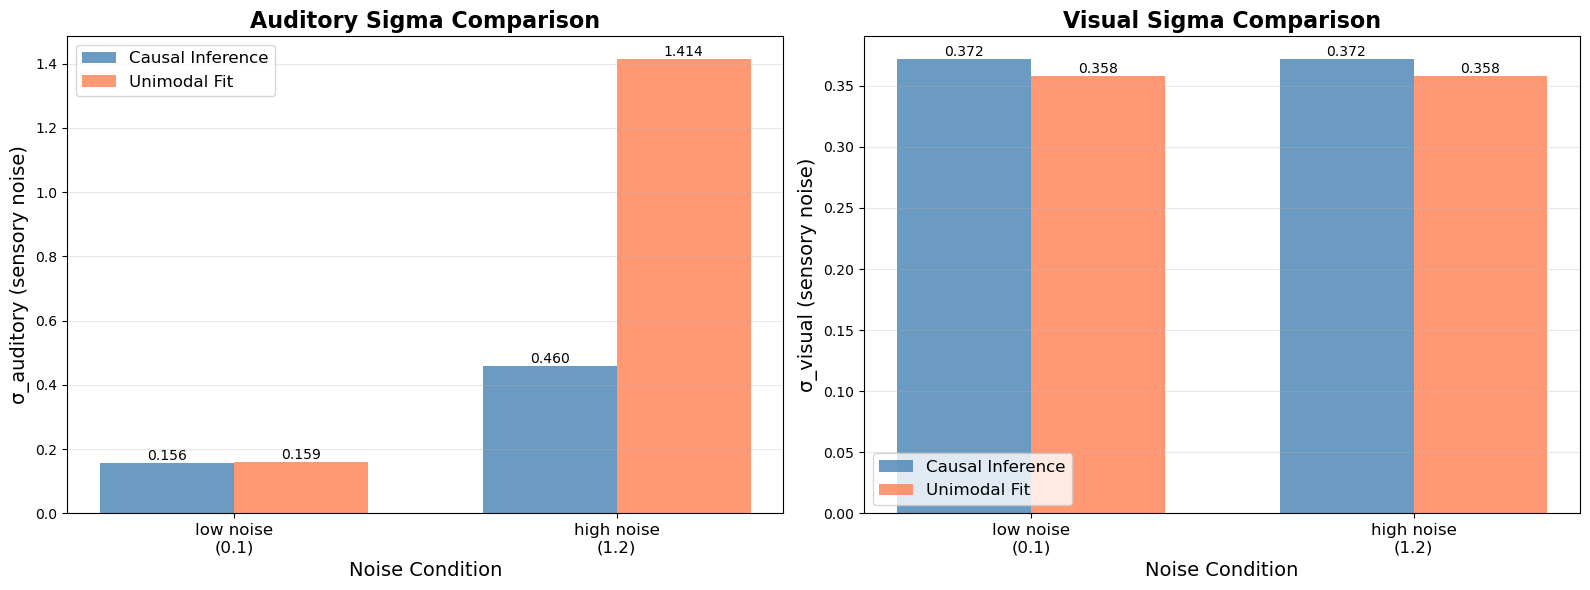


Sigma Validation: Unimodal vs Causal Inference

Comparison of sensory noise estimates:
• Unimodal fits: σ_fitted / √2 (2IFC discrimination → sensory noise)
• Causal Inference: σ_model (direct sensory noise parameters)
Both should represent the same underlying sensory noise sources.


LOW NOISE (noise=0.1):
  Auditory:
    Causal Inference: σ = 0.1558
    Unimodal Fit:     σ = 0.1594
    Difference:       Δσ = 0.0036 (2.3%)
  Visual:
    Causal Inference: σ = 0.3719
    Unimodal Fit:     σ = 0.3582
    Difference:       Δσ = 0.0137 (3.8%)

HIGH NOISE (noise=1.2):
  Auditory:
    Causal Inference: σ = 0.4601
    Unimodal Fit:     σ = 1.4142
    Difference:       Δσ = 0.9541 (67.5%)
  Visual:
    Causal Inference: σ = 0.3719
    Unimodal Fit:     σ = 0.3582
    Difference:       Δσ = 0.0137 (3.8%)

Overall Correlation: r = 0.739


In [19]:
import matplotlib.pyplot as plt
import numpy as np

def plot_sigma_comparison(self, forced_fusion_params, aud_params_by_noise, vis_params):
    """
    Compare unimodal sigma estimates with causal inference model sigmas.
    
    Important: The fitted sigma from psychometric functions is the discrimination threshold
    for the 2IFC task. Since participants compare two measurements (test vs standard),
    each measurement has sensory noise σ_sensory, and the difference has noise σ_diff = σ_sensory * √2.
    
    Therefore: σ_sensory = σ_fitted / √2
    """
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Get causal inference sigmas for each condition
    # Extract from model fit
    sigma_data = []
    
    for noise_idx, audioNoiseLevel in enumerate(sorted(self.uniqueSensory)):
        # Get causal inference parameters
        # Typically: lambda, sigma_aud, sigma_vis, p_c, tmin, tmax
        # NOTE: These sigma values are SENSORY NOISE (not 2IFC discrimination thresholds)
        conflict = self.uniqueConflict[0]  # Use first conflict (usually 0)
        lambda_, sigma_ci_aud, sigma_ci_vis, p_c, tmin, tmax = self.getParamsCausal(
            self.modelFit, audioNoiseLevel, conflict
        )
        
        # Get unimodal sigmas (already divided by √2 in forced_fusion_params)
        if audioNoiseLevel not in self.noise_to_condition:
            continue
        condition_name = self.noise_to_condition[audioNoiseLevel]
        sigma_uni_aud = forced_fusion_params[condition_name]['sigma_aud']
        sigma_uni_vis = forced_fusion_params[condition_name]['sigma_vis']
        
        sigma_data.append({
            'noise_level': audioNoiseLevel,
            'condition': condition_name,
            'ci_aud': sigma_ci_aud,
            'ci_vis': sigma_ci_vis,
            'uni_aud': sigma_uni_aud,
            'uni_vis': sigma_uni_vis
        })
    
    # Plot 1: Auditory Sigma Comparison
    ax1 = axes[0]
    ci_aud_vals = [d['ci_aud'] for d in sigma_data]
    uni_aud_vals = [d['uni_aud'] for d in sigma_data]
    noise_labels = [f"{d['condition'].replace('_', ' ')}\n({d['noise_level']})" for d in sigma_data]
    
    x = np.arange(len(sigma_data))
    width = 0.35
    
    bars1 = ax1.bar(x - width/2, ci_aud_vals, width, label='Causal Inference', 
                    color='steelblue', alpha=0.8)
    bars2 = ax1.bar(x + width/2, uni_aud_vals, width, label='Unimodal Fit', 
                    color='coral', alpha=0.8)
    
    ax1.set_xlabel('Noise Condition', fontsize=14)
    ax1.set_ylabel('σ_auditory (sensory noise)', fontsize=14)
    ax1.set_title('Auditory Sigma Comparison', fontsize=16, fontweight='bold')
    ax1.set_xticks(x)
    ax1.set_xticklabels(noise_labels, fontsize=12)
    ax1.legend(fontsize=12)
    ax1.grid(axis='y', alpha=0.3)
    
    # Add value labels on bars
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.3f}', ha='center', va='bottom', fontsize=10)
    
    # Plot 2: Visual Sigma Comparison
    ax2 = axes[1]
    ci_vis_vals = [d['ci_vis'] for d in sigma_data]
    uni_vis_vals = [d['uni_vis'] for d in sigma_data]
    
    # Visual should be same across conditions - plot as horizontal lines
    bars1 = ax2.bar(x - width/2, ci_vis_vals, width, label='Causal Inference', 
                    color='steelblue', alpha=0.8)
    bars2 = ax2.bar(x + width/2, uni_vis_vals, width, label='Unimodal Fit', 
                    color='coral', alpha=0.8)
    
    ax2.set_xlabel('Noise Condition', fontsize=14)
    ax2.set_ylabel('σ_visual (sensory noise)', fontsize=14)
    ax2.set_title('Visual Sigma Comparison', fontsize=16, fontweight='bold')
    ax2.set_xticks(x)
    ax2.set_xticklabels(noise_labels, fontsize=12)
    ax2.legend(fontsize=12)
    ax2.grid(axis='y', alpha=0.3)
    
    # Add value labels on bars
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax2.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.3f}', ha='center', va='bottom', fontsize=10)
    
    plt.tight_layout()
    plt.show()
    
    # Print comparison statistics
    print("\n" + "="*60)
    print("Sigma Validation: Unimodal vs Causal Inference")
    print("="*60)
    print("\nComparison of sensory noise estimates:")
    print("• Unimodal fits: σ_fitted / √2 (2IFC discrimination → sensory noise)")
    print("• Causal Inference: σ_model (direct sensory noise parameters)")
    print("Both should represent the same underlying sensory noise sources.\n")
    
    for data in sigma_data:
        print(f"\n{data['condition'].upper().replace('_', ' ')} (noise={data['noise_level']}):")
        print(f"  Auditory:")
        print(f"    Causal Inference: σ = {data['ci_aud']:.4f}")
        print(f"    Unimodal Fit:     σ = {data['uni_aud']:.4f}")
        diff_aud = abs(data['ci_aud'] - data['uni_aud'])
        pct_diff_aud = (diff_aud / data['uni_aud']) * 100
        print(f"    Difference:       Δσ = {diff_aud:.4f} ({pct_diff_aud:.1f}%)")
        
        print(f"  Visual:")
        print(f"    Causal Inference: σ = {data['ci_vis']:.4f}")
        print(f"    Unimodal Fit:     σ = {data['uni_vis']:.4f}")
        diff_vis = abs(data['ci_vis'] - data['uni_vis'])
        pct_diff_vis = (diff_vis / data['uni_vis']) * 100
        print(f"    Difference:       Δσ = {diff_vis:.4f} ({pct_diff_vis:.1f}%)")
    
    print("\n" + "="*60)
    
    # Calculate correlation if we have multiple data points
    if len(sigma_data) >= 2:
        all_ci = np.array(ci_aud_vals + ci_vis_vals)
        all_uni = np.array(uni_aud_vals + uni_vis_vals)
        correlation = np.corrcoef(all_ci, all_uni)[0, 1]
        print(f"Overall Correlation: r = {correlation:.3f}")
        print("="*60)
    
    return sigma_data

# Generate the comparison plot
sigma_comparison = plot_sigma_comparison(mc_fitter, forced_fusion_params, aud_params_by_noise, vis_params)


# Batch Analysis: All Participants Causal Inference Plots

Now we'll create a comprehensive visualization showing all 12 participants' causal inference model fits in a single 4x3 subplot layout.

Loading and plotting 12 participants...

Processing participant 1/12: as_all.csv

 Total trials before cleaning
: 2156
uniqueSensory: [1.2 0.1] 
 uniqueStandard: [0.5] 
 uniqueConflict: [np.float64(-0.25), np.float64(-0.17), np.float64(-0.08), np.float64(0.0), np.float64(0.08), np.float64(0.17), np.float64(0.25)]
total trials after cleaning: 2156
Created logDurRatio variable: range [-2.997, 0.643]
  → This represents log(test/standard) for Weber's law compliance
Looking for saved fit: as_all with model lognorm_LapseFree_sharedPrior
  ✅ Loaded saved causal inference fit for as
Loaded saved simulated data from simulated_data/as/as_lognorm_LapseFree_sharedPrior_simulated.csv
  ✅ Loaded simulated data for as
Created logDurRatio variable: range [-3.157, 0.646]
  → This represents log(test/standard) for Weber's law compliance
  ✅ Fitted simulated psychometric curves for as
  ✅ Successfully plotted as

Processing participant 2/12: oy_all.csv

 Total trials before cleaning
: 2171
uniqueSensory

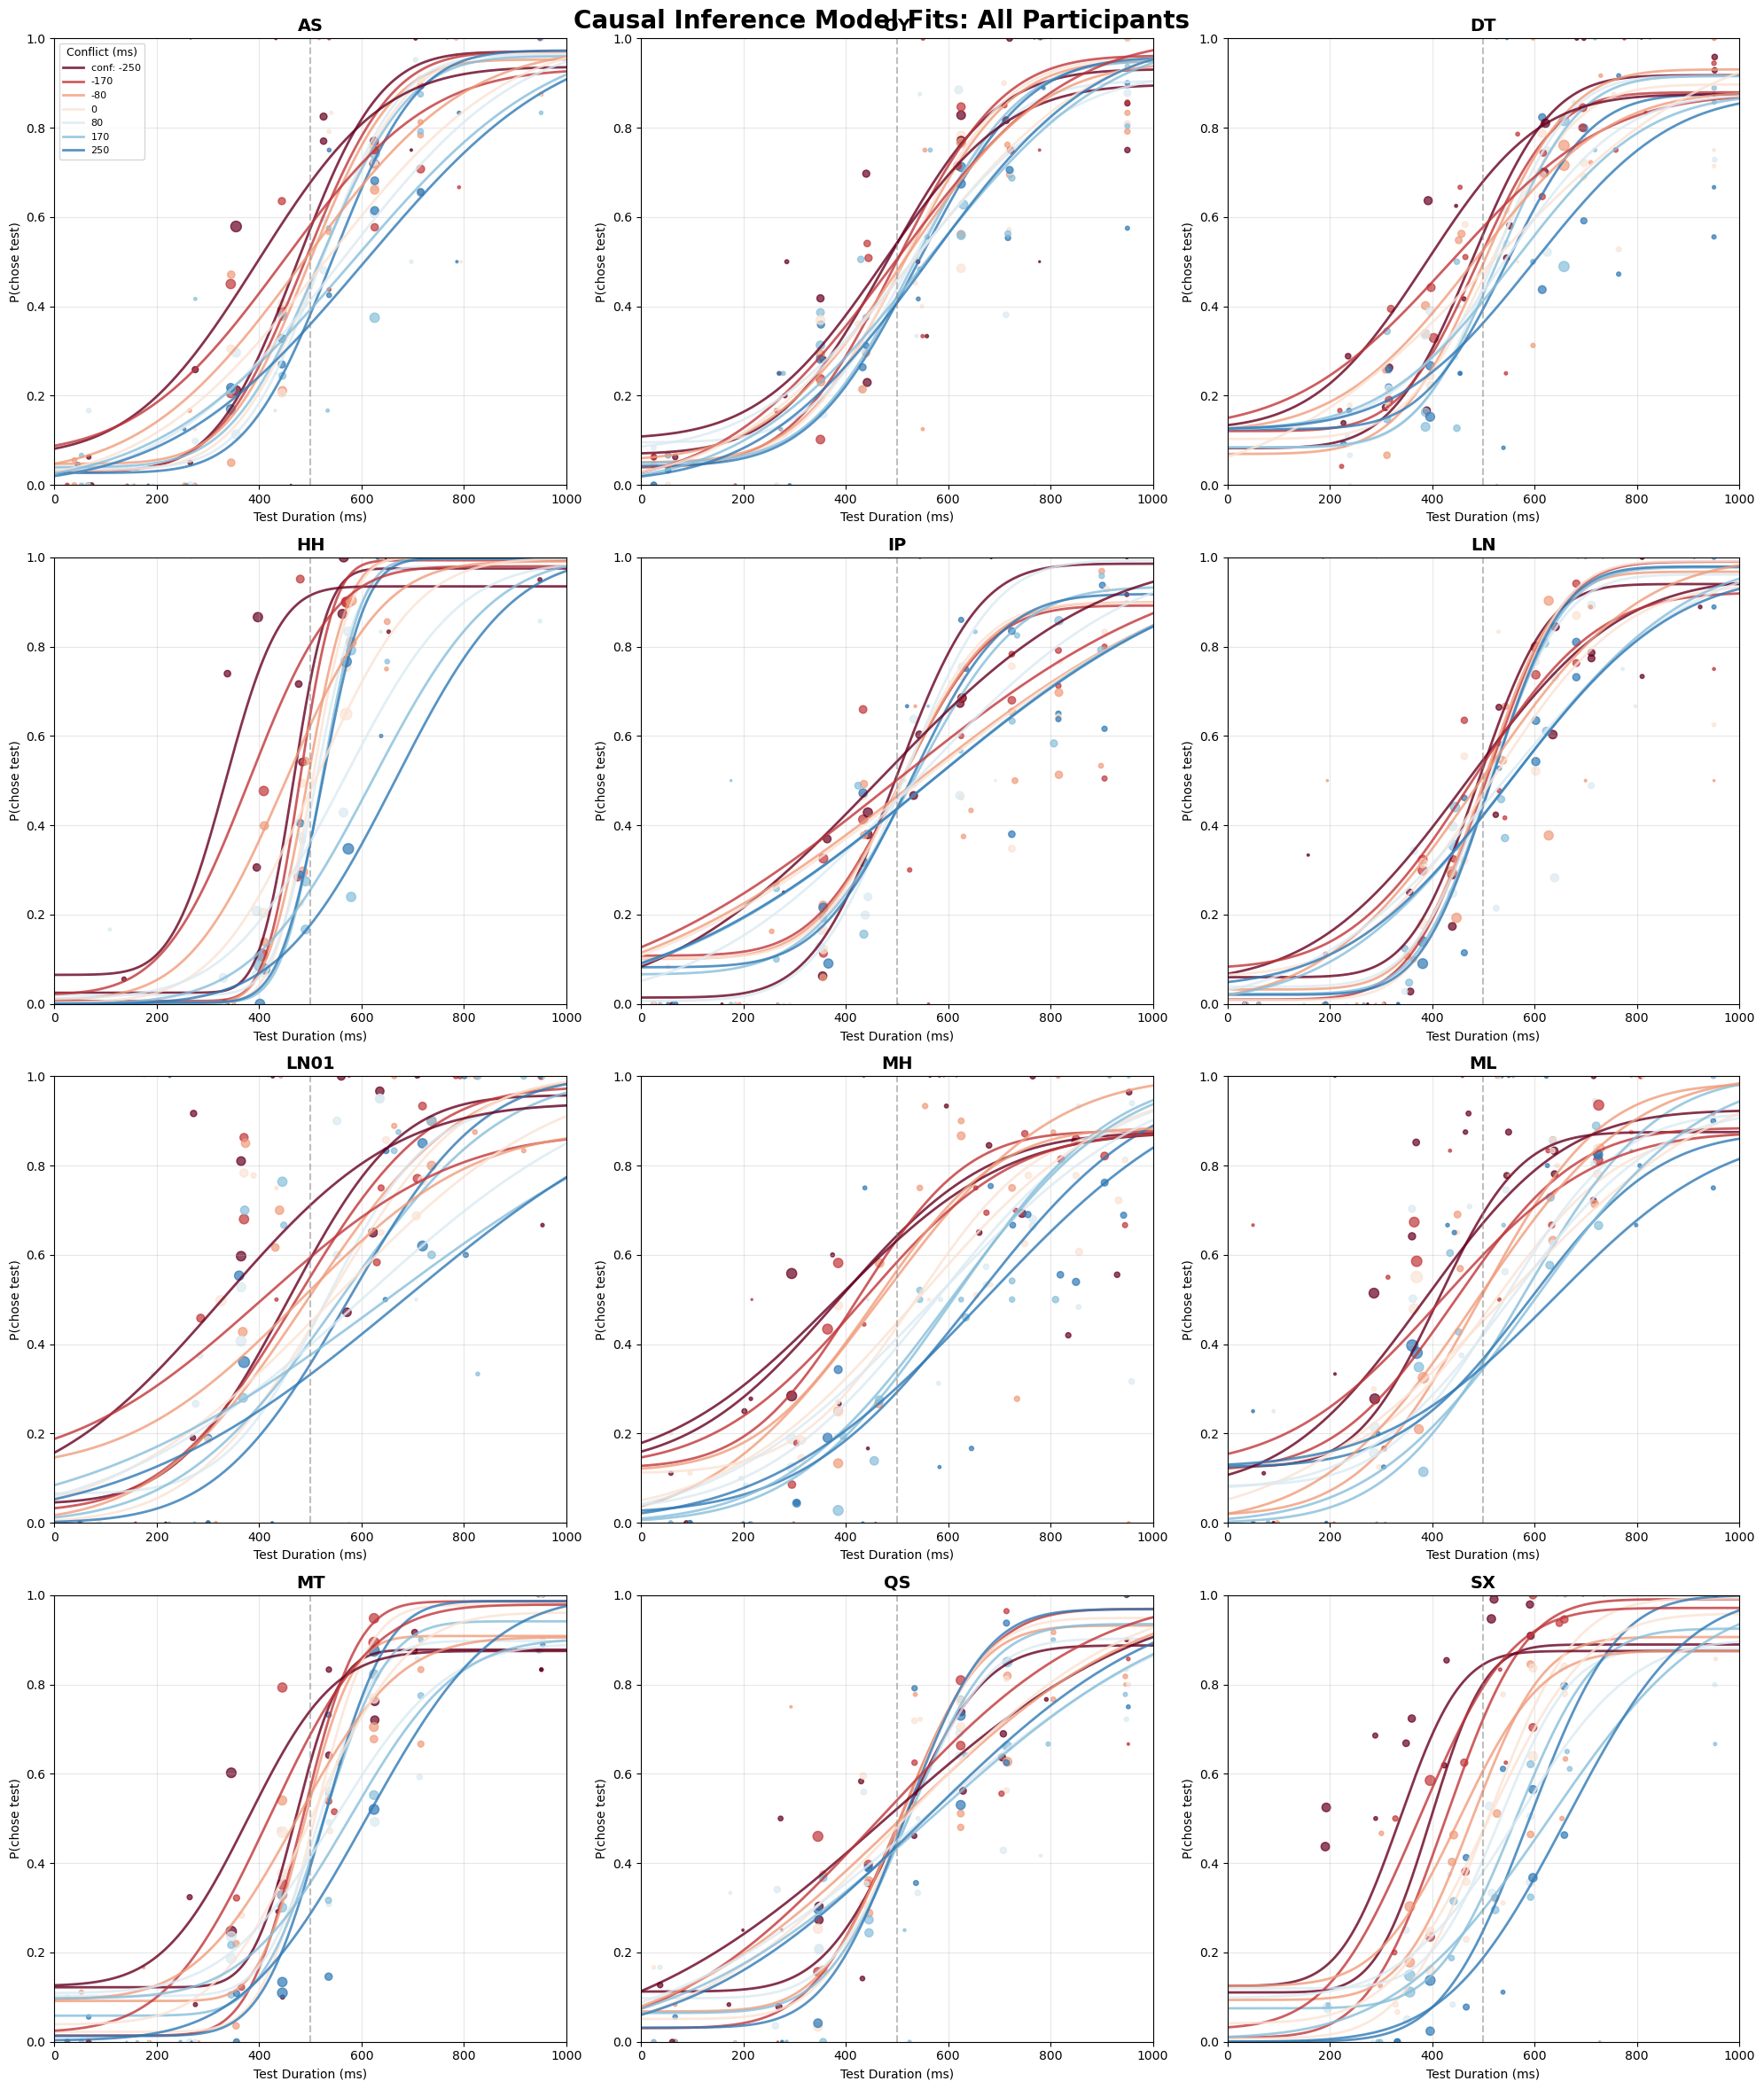


✅ Completed batch plotting for all participants!


In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import loadData
import monteCarloClass
import psychometricFitLoader as pfl_data
import loadResults
from loadSimData import loadSimulatedData

def plot_all_participants_causal_inference():
    """
    Create a 4x3 subplot showing causal inference model fits for all 12 participants.
    """
    # List of all participant filenames
    participant_files = [
        "as_all.csv", "oy_all.csv", "dt_all.csv", "HH_all.csv", 
        "ip_all.csv", "ln_all.csv", "LN01_all.csv", "mh_all.csv", 
        "ml_all.csv", "mt_all.csv", "qs_all.csv", "sx_all.csv"
    ]
    
    # Create figure with 4x3 subplots
    fig, axes = plt.subplots(4, 3, figsize=(20, 24))
    axes = axes.flatten()  # Make it easier to index
    
    print(f"Loading and plotting {len(participant_files)} participants...")
    
    for idx, filename in enumerate(participant_files):
        print(f"\nProcessing participant {idx+1}/12: {filename}")
        
        try:
            # Load participant data
            data, dataName = loadData.loadData(filename)
            participant_id = dataName.split("_")[0]
            
            # Initialize Monte Carlo fitter
            mc_fitter_temp = monteCarloClass.OmerMonteCarlo(data)
            mc_fitter_temp.nStart = 1
            mc_fitter_temp.nSimul = 500
            mc_fitter_temp.optimizationMethod = "bads"
            mc_fitter_temp.modelName = "lognorm"
            mc_fitter_temp.integrationMethod = "analytical"
            mc_fitter_temp.freeP_c = False
            mc_fitter_temp.sharedLambda = False
            mc_fitter_temp.dataName = dataName
            
            # Load saved model fit results
            try:
                res = loadResults.loadFitResults(mc_fitter_temp, dataName, modelName=mc_fitter_temp.modelName)
                mc_fitter_temp.modelFit = res['fittedParams']
                print(f"  ✅ Loaded saved causal inference fit for {participant_id}")
            except Exception as e:
                print(f"  ❌ No saved causal inference fit found for {participant_id}: {str(e)}")
                continue
            
            # Load simulated data
            try:
                mc_fitter_temp.simulatedData = loadSimulatedData(
                    fitter=mc_fitter_temp, 
                    dataName=mc_fitter_temp.dataName, 
                    participantID=dataName.split(".csv")[0], 
                    modelType=mc_fitter_temp.modelName
                )
                print(f"  ✅ Loaded simulated data for {participant_id}")
            except Exception as e:
                print(f"  ❌ No simulated data found for {participant_id}: {str(e)}")
                continue
            
            # Fit simulated data (don't need to load psychometric fit for plotting)
            try:
                mc_fitter_temp.simDataFit = mc_fitter_temp.fitMultipleStartingPoints(mc_fitter_temp.simulatedData, 1)
                print(f"  ✅ Fitted simulated psychometric curves for {participant_id}")
            except Exception as e:
                print(f"  ❌ Failed to fit simulated data for {participant_id}: {str(e)}")
                continue
            
            # Plot psychometric curves for this participant
            ax = axes[idx]
            plt.sca(ax)  # Set current axes
            
            # Plot data for each condition
            for i, standardLevel in enumerate(mc_fitter_temp.uniqueStandard):
                for j, audioNoiseLevel in enumerate(sorted(mc_fitter_temp.uniqueSensory)):
                    for k, conflictLevel in enumerate(mc_fitter_temp.uniqueConflict):
                        
                        # Generate color for this conflict level
                        color = sns.color_palette("RdBu", as_cmap=True)(k / len(mc_fitter_temp.uniqueConflict))
                        
                        # Get psychometric parameters from simulated fit
                        paramsSimFit = mc_fitter_temp.getParams(mc_fitter_temp.simDataFit.x, conflictLevel, audioNoiseLevel)
                        
                        # Plot psychometric curve
                        x = np.linspace(-0.6, 0.6, 1000)
                        ySimSigmoid = mc_fitter_temp.psychometric_function(x, paramsSimFit[0], paramsSimFit[1], paramsSimFit[2])
                        
                        xPlot = np.linspace(0, 1000, 1000)
                        if audioNoiseLevel == sorted(mc_fitter_temp.uniqueSensory)[0]:  # Only show legend for first noise condition
                            if k == 0:
                                ax.plot(xPlot, ySimSigmoid, color=color, linestyle='-', 
                                       label=f"conf: {int(conflictLevel*1000)}", linewidth=2, alpha=0.8)
                            else:
                                ax.plot(xPlot, ySimSigmoid, color=color, linestyle='-', 
                                       linewidth=2, alpha=0.8, label=f"{int(conflictLevel*1000)}")
                        else:
                            ax.plot(xPlot, ySimSigmoid, color=color, linestyle='-', linewidth=2, alpha=0.8)
                        
                        # Bin and plot actual data points
                        groupedDataSub = mc_fitter_temp.groupByChooseTest(
                            mc_fitter_temp.data[
                                (mc_fitter_temp.data[mc_fitter_temp.standardVar] == standardLevel) & 
                                (mc_fitter_temp.data[mc_fitter_temp.sensoryVar] == audioNoiseLevel) & 
                                (mc_fitter_temp.data[mc_fitter_temp.conflictVar] == conflictLevel)
                            ],
                            [mc_fitter_temp.intensityVar, mc_fitter_temp.sensoryVar, mc_fitter_temp.standardVar, 
                             mc_fitter_temp.conflictVar, mc_fitter_temp.visualStandardVar, 
                             mc_fitter_temp.visualTestVar, mc_fitter_temp.audioTestVar, "testDurMs"]
                        )
                        
                        # Simple binning and plotting function
                        if len(groupedDataSub) > 0:
                            groupedDataSub['bin'] = pd.cut(groupedDataSub['testDurMs'], bins=10, labels=False, include_lowest=True)
                            grouped = groupedDataSub.groupby('bin').agg(
                                x_mean=('testDurMs', 'mean'),
                                y_mean=('p_choose_test', 'mean'),
                                total_resp=('total_responses', 'sum')
                            )
                            ax.scatter(grouped['x_mean'], grouped['y_mean'], 
                                     s=grouped['total_resp']/groupedDataSub['total_responses'].sum()*200, 
                                     color=color, alpha=0.7)
            
            # Add reference line at 500ms
            ax.axvline(500, linestyle='--', color='gray', alpha=0.5)
            
            # Format subplot
            ax.set_title(f"{participant_id.upper()}", fontsize=14, fontweight='bold')
            ax.set_xlabel("Test Duration (ms)", fontsize=10)
            ax.set_ylabel("P(chose test)", fontsize=10)
            ax.grid(True, alpha=0.3)
            ax.set_xlim(0, 1000)
            ax.set_ylim(0, 1)
            
            # Add legend only to first subplot
            if idx == 0:
                ax.legend(fontsize=8, title="Conflict (ms)", title_fontsize=9)
            
            print(f"  ✅ Successfully plotted {participant_id}")
            
        except Exception as e:
            print(f"  ❌ Error processing {filename}: {str(e)}")
            # Create empty subplot with error message
            ax = axes[idx]
            ax.text(0.5, 0.5, f"Error loading\n{filename.split('_')[0].upper()}", 
                   ha='center', va='center', transform=ax.transAxes, fontsize=12)
            ax.set_title(f"{filename.split('_')[0].upper()}", fontsize=14, fontweight='bold')
            continue
    
    # Remove any unused subplots
    for idx in range(len(participant_files), len(axes)):
        fig.delaxes(axes[idx])
    
    plt.suptitle("Causal Inference Model Fits: All Participants", fontsize=20, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.show()
    
    print(f"\n✅ Completed batch plotting for all participants!")

# Run the batch plotting function
plot_all_participants_causal_inference()

## Batch Analysis: PSE vs Conflict Plots (Bootstrap + Model Comparison)

For each participant:
1. Load/generate bootstrap parameters (nBoots=1 for speed)
2. Save and load back bootstrapped parameters
3. Plot PSE shift vs conflict level comparing data (bootstrap) and causal inference model

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import loadData
import monteCarloClass
import psychometricFitLoader as pfl_data
import loadResults
from loadSimData import loadSimulatedData
from bootstrapperSaveLoad import saveBootstrappedParams, loadBootstrappedParams

def plot_all_participants_mu_vs_conflict():
    """
    Create a 4x3 subplot showing PSE shift vs conflict for all 12 participants.
    Compares bootstrapped data with causal inference model predictions.
    """
    # List of all participant filenames
    participant_files = [
        "as_all.csv", "oy_all.csv", "dt_all.csv", "HH_all.csv", 
        "ip_all.csv", "ln_all.csv", "LN01_all.csv", "mh_all.csv", 
        "ml_all.csv", "mt_all.csv", "qs_all.csv", "sx_all.csv"
    ]
    
    # Create figure with 4x3 subplots
    fig, axes = plt.subplots(4, 3, figsize=(20, 24))
    axes = axes.flatten()  # Make it easier to index
    
    nBoots = 1  # Small number for speed
    
    print(f"Loading and plotting {len(participant_files)} participants...")
    
    for idx, filename in enumerate(participant_files):
        print(f"\n{'='*60}")
        print(f"Processing participant {idx+1}/12: {filename}")
        print(f"{'='*60}")
        
        try:
            # Load participant data
            data, dataName = loadData.loadData(filename)
            participant_id = dataName.split("_")[0]
            
            # Initialize Monte Carlo fitter
            mc_fitter_temp = monteCarloClass.OmerMonteCarlo(data)
            mc_fitter_temp.nStart = 1
            mc_fitter_temp.nSimul = 500
            mc_fitter_temp.optimizationMethod = "bads"
            mc_fitter_temp.modelName = "lognorm"
            mc_fitter_temp.integrationMethod = "analytical"
            mc_fitter_temp.freeP_c = False
            mc_fitter_temp.sharedLambda = False
            mc_fitter_temp.dataName = dataName
            
            # Load saved causal inference model fit
            try:
                res = loadResults.loadFitResults(mc_fitter_temp, dataName, modelName=mc_fitter_temp.modelName)
                mc_fitter_temp.modelFit = res['fittedParams']
                print(f"  ✅ Loaded causal inference fit for {participant_id}")
            except Exception as e:
                print(f"  ❌ No causal inference fit found for {participant_id}: {str(e)}")
                continue
            
            # Load simulated data
            try:
                mc_fitter_temp.simulatedData = loadSimulatedData(
                    fitter=mc_fitter_temp, 
                    dataName=mc_fitter_temp.dataName, 
                    participantID=dataName.split(".csv")[0], 
                    modelType=mc_fitter_temp.modelName
                )
                print(f"  ✅ Loaded simulated data for {participant_id}")
            except Exception as e:
                print(f"  ❌ No simulated data found for {participant_id}: {str(e)}")
                continue
            
            # Load psychometric fit for data
            try:
                mc_fitter_temp.dataFit = pfl_data.load_psychometric_fit(participant_id)
                
                # Create SimpleNamespace for compatibility
                def SimpleNamespace(**kwargs):
                    class Namespace:
                        def __init__(self, **kwargs):
                            for key, value in kwargs.items():
                                setattr(self, key, value)
                    return Namespace(**kwargs)
                
                mc_fitter_temp.dataFit = SimpleNamespace(**mc_fitter_temp.dataFit)
                mc_fitter_temp.dataFit.x = mc_fitter_temp.dataFit.parameters
                print(f"  ✅ Loaded psychometric fit for {participant_id}")
            except Exception as e:
                print(f"  ❌ No psychometric fit found for {participant_id}: {str(e)}")
                continue
            
            # Fit simulated data
            try:
                mc_fitter_temp.simDataFit = mc_fitter_temp.fitMultipleStartingPoints(mc_fitter_temp.simulatedData, 1)
                print(f"  ✅ Fitted simulated psychometric curves for {participant_id}")
            except Exception as e:
                print(f"  ❌ Failed to fit simulated data for {participant_id}: {str(e)}")
                continue
            
            # Bootstrap parameters
            print(f"  🔄 Generating bootstrap parameters (nBoots={nBoots})...")
            try:
                # Try to load existing bootstrapped parameters
                try:
                    loadBootstrappedParams(mc_fitter_temp, mc_fitter_temp.dataName)
                    dataBoots = mc_fitter_temp.bootstrappedParams
                    print(f"  ✅ Loaded existing bootstrapped parameters for {participant_id}")
                except:
                    # Generate new bootstraps
                    dataBoots = mc_fitter_temp.paramBootstrap(mc_fitter_temp.dataFit.x, nBoots=nBoots)
                    # Save bootstrapped parameters
                    saveBootstrappedParams(mc_fitter_temp, dataBoots, mc_fitter_temp.dataName)
                    # Load back to verify
                    loadBootstrappedParams(mc_fitter_temp, mc_fitter_temp.dataName)
                    print(f"  ✅ Generated and saved bootstrapped parameters for {participant_id}")
            except Exception as e:
                print(f"  ❌ Bootstrap failed for {participant_id}: {str(e)}")
                continue
            
            # Plot mu vs conflict for this participant
            ax = axes[idx]
            plt.sca(ax)  # Set current axes
            
            # Plot for each noise condition
            for j, audioNoiseLevel in enumerate(sorted(mc_fitter_temp.uniqueSensory)):
                conflict_levels = []
                mu_models = []
                
                for k, conflictLevel in enumerate(mc_fitter_temp.uniqueConflict):
                    conflict_levels.append(conflictLevel)
                    
                    # Color scheme based on noise level
                    if audioNoiseLevel == sorted(mc_fitter_temp.uniqueSensory)[0]:
                        color = sns.color_palette("Reds", as_cmap=True)(0.2 + 0.8 * (k / len(mc_fitter_temp.uniqueConflict)))
                    else:
                        color = sns.color_palette("Blues", as_cmap=True)(0.2 + 0.8 * (k / len(mc_fitter_temp.uniqueConflict)))
                    
                    # Get bootstrap means
                    bootMus = [mc_fitter_temp.getParams(boot, conflictLevel, audioNoiseLevel)[1] for boot in dataBoots]
                    mu_data_mean = np.mean(bootMus)
                    mu_data_std = np.std(bootMus)
                    
                    # Plot data with error bars
                    ax.errorbar(conflictLevel, mu_data_mean, yerr=mu_data_std, 
                               color=color, fmt='o', capsize=3, alpha=1, markersize=5)
                    
                    # Get model prediction
                    paramsSimDf = mc_fitter_temp.getParams(mc_fitter_temp.simDataFit.x, conflictLevel, audioNoiseLevel)
                    muModel = paramsSimDf[1]
                    mu_models.append(muModel)
                    
                    ax.plot(conflictLevel, muModel, color="black", alpha=0.8, 
                           linestyle='--', marker='o', markersize=4)
                
                # Connect model predictions with line
                conflict_levels = np.array(conflict_levels)
                mu_models = np.array(mu_models)
                sorted_indices = np.argsort(conflict_levels)
                ax.plot(conflict_levels[sorted_indices], mu_models[sorted_indices], 
                       color="black", alpha=0.5, linestyle='--', linewidth=1)
            
            # Format subplot
            ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
            ax.axvline(x=0, color='gray', linestyle='--', alpha=0.5)
            ax.set_title(f"{participant_id.upper()}", fontsize=14, fontweight='bold')
            ax.set_xlabel("Conflict (s)", fontsize=10)
            ax.set_ylabel("PSE shift (log space)", fontsize=10)
            ax.set_ylim(-0.35, 0.35)
            ax.grid(True, alpha=0.3)
            ax.tick_params(labelsize=9)
            
            # Add legend only to first subplot
            if idx == 0:
                ax.plot([], [], 'o', color='gray', label='Data (bootstrap)', markersize=5)
                ax.plot([], [], 'o', color='black', label='Causal Inf.', markersize=5)
                ax.legend(fontsize=8, loc='upper left')
            
            print(f"  ✅ Successfully plotted {participant_id}")
            
        except Exception as e:
            print(f"  ❌ Error processing {filename}: {str(e)}")
            import traceback
            traceback.print_exc()
            
            # Create empty subplot with error message
            ax = axes[idx]
            ax.text(0.5, 0.5, f"Error loading\n{filename.split('_')[0].upper()}", 
                   ha='center', va='center', transform=ax.transAxes, fontsize=12, color='red')
            ax.set_title(f"{filename.split('_')[0].upper()}", fontsize=14, fontweight='bold')
            ax.set_xlabel("Conflict (s)", fontsize=10)
            ax.set_ylabel("PSE shift (log space)", fontsize=10)
            continue
    
    # Remove any unused subplots
    for idx in range(len(participant_files), len(axes)):
        fig.delaxes(axes[idx])
    
    plt.suptitle("PSE Shift vs Conflict: All Participants (Data vs Causal Inference)", 
                fontsize=20, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()
    
    print(f"\n{'='*60}")
    print(f"✅ Completed batch plotting for all participants!")
    print(f"{'='*60}")

# Run the batch plotting function
plot_all_participants_mu_vs_conflict()

Loading and plotting 12 participants...

Processing participant 1/12: as_all.csv

 Total trials before cleaning
: 2156
uniqueSensory: [1.2 0.1] 
 uniqueStandard: [0.5] 
 uniqueConflict: [np.float64(-0.25), np.float64(-0.17), np.float64(-0.08), np.float64(0.0), np.float64(0.08), np.float64(0.17), np.float64(0.25)]
total trials after cleaning: 2156
Created logDurRatio variable: range [-2.997, 0.643]
  → This represents log(test/standard) for Weber's law compliance
Looking for saved fit: as_all with model lognorm_LapseFree_sharedPrior
  ✅ Loaded causal inference fit for as
Loaded saved simulated data from simulated_data/as/as_lognorm_LapseFree_sharedPrior_simulated.csv
  ✅ Loaded simulated data for as
  ✅ Loaded psychometric fit for as
Created logDurRatio variable: range [-3.157, 0.646]
  → This represents log(test/standard) for Weber's law compliance
  ✅ Fitted simulated psychometric curves for as
  🔄 Generating bootstrap parameters (nBoots=1)...
Bootstrapped parameters file not found: b

Bootstrapping: 100%|██████████| 1/1 [00:12<00:00, 12.11s/iteration]


Bootstrapped parameters saved to bootstrapped_params/as/as_lognorm_LapseFree_sharedPrior_bootstrapped_params.json
Saved array shape: (1, 42)
Bootstrapped parameters file not found: bootstrapped_params/as/as_gaussian_LapseFree_sharedPrior_bootstrapped_params.json
  ✅ Generated and saved bootstrapped parameters for as
  ✅ Successfully plotted as

Processing participant 2/12: oy_all.csv

 Total trials before cleaning
: 2171
uniqueSensory: [1.2 0.1] 
 uniqueStandard: [0.5] 
 uniqueConflict: [np.float64(-0.25), np.float64(-0.17), np.float64(-0.08), np.float64(0.0), np.float64(0.08), np.float64(0.17), np.float64(0.25)]
total trials after cleaning: 2171
Created logDurRatio variable: range [-2.993, 0.645]
  → This represents log(test/standard) for Weber's law compliance
Looking for saved fit: oy_all with model lognorm_LapseFree_sharedPrior
  ✅ Loaded causal inference fit for oy
Loaded saved simulated data from simulated_data/oy/oy_lognorm_LapseFree_sharedPrior_simulated.csv
  ✅ Loaded simulate